# Optimization sweep

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from training_helpers import *

## Define baseline

In [2]:
preamble_lengths = [8, 16, 32]
snr_range = np.arange(-10,11)

baselines = {}
for length in preamble_lengths:
    baselines[length] = calculate_baseline(signal.max_len_seq(6)[0][:length], snr_range, num_iter=1500, payload=128, signal_length=200, add_phase_offset=True, carrier_offset=None)

## Sequential FCN

In [3]:
class preamble_detector(nn.Module):
    def __init__(self, num_layers, num_filters, width):
        super(preamble_detector, self).__init__()
        
        pad = int((width-1)/2)
        
        self.conv = torch.nn.Sequential()
        
        self.conv.add_module("conv0", torch.nn.Conv2d(1, num_filters, (2,width), 1, padding=(0,pad)))
        self.conv.add_module(f"relu0", torch.nn.ReLU())
        
        for i in range(num_layers-2):
            self.conv.add_module(f"conv{i+1}", nn.Conv2d(num_filters, num_filters, (1,width), 1, padding=(0,pad)))
            self.conv.add_module(f"relu{i+1}", torch.nn.ReLU())
        
        self.conv.add_module(f"conv_last", nn.Conv2d(num_filters, 1, 1, 1))

    def forward(self, x):

        # Do all convolutions
        x = self.conv(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x

In [4]:
def find_best_worst(results):
    best_acc = 0
    worst_acc = 100
    for idx, result in enumerate(results):
        mean_acc = np.mean(1-np.array(result['ders']))
        if mean_acc < worst_acc:
            worst_acc = mean_acc
            worst_idx = idx
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_idx = idx
    return best_idx, worst_idx

## Regularization exploration

In [5]:
train_snrs = [10, 5, 0]
preamble_lengths = [8, 16, 32]

num_models = 5
num_epochs = 30
batch_size = 32
lr = 0.001
regs = [0, 0.001, 0.01]

add_cfo = True
max_cfo = 10e3
num_data = 8192

num_layers = 3
num_filters = 32
filter_width = 35

# loss_fn = nn.MSELoss()
# loss_fn = nn.CrossEntropyLoss()
loss_fns = [nn.MSELoss(), nn.CrossEntropyLoss()]

In [6]:
for train_snr, preamble_length in zip(train_snrs, preamble_lengths):
    print(f'Training {preamble_length}-bit models on {train_snr}dB SNR...')
    for reg in regs:
        print(f'Weight decay {reg}')
        for loss_fn in loss_fns:
            print(f'Using {str(loss_fn)} loss')
            # training data
            train_data, labels = gen_training_data(signal.max_len_seq(6)[0][:preamble_length], num_examples=num_data, snr=train_snr, add_phase_offset=True, 
                                                   add_carrier_offset=add_cfo, max_carrier_offset=max_cfo)
            train_data, labels = preprocess(train_data, labels)

            train_dataset = torch.utils.data.TensorDataset(train_data, labels)
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            # validation data
            val_data, val_labels = gen_training_data(signal.max_len_seq(6)[0][:preamble_length], num_examples=256, snr=train_snr, add_phase_offset=True,
                                                     add_carrier_offset=add_cfo)
            val_data, val_labels = preprocess(val_data, val_labels)

            val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            models = []
            for i in range(num_models):
                print(f'Model {i}...')
                torch.manual_seed(i)
                detector = preamble_detector(num_layers, num_filters, filter_width)
                detector.cuda()

                optimizer = optim.Adam(detector.parameters(), lr=lr, weight_decay=reg)

                detector, losses, val_losses, accs, val_accs = train_model(detector, optimizer, loss_fn, train_loader, val_loader, num_epochs=num_epochs)

                model_config = {"weights": detector.state_dict(),
                                "losses": losses,
                                "val_losses": val_losses,
                                "accs": accs,
                                "val_accs": val_accs,
                                "num_epochs": num_epochs,
                                "lr": lr,
                                "reg": reg}

                models.append(model_config)
            torch.save(models, f"models/{preamble_length}_preamble_{train_snr}_cfo_{add_cfo}_{str(loss_fn).strip('()')}_reg_{reg}.pt")

Training 8-bit models on 10dB SNR...
Weight decay 0
Using MSELoss() loss
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Using CrossEntropyLoss() loss
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Weight decay 0.001
Using MSELoss() loss
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Using CrossEntropyLoss() loss
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Weight decay 0.01
Using MSELoss() loss
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Using CrossEntropyLoss() loss
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Training 16-bit models on 5dB SNR...
Weight decay 0
Using MSELoss() loss
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Using CrossEntropyLoss() loss
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Weight decay 0.001
Using MSELoss() loss
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Using CrossEntropyLoss() loss
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Weight decay 0.01
Using MSELoss() l

In [7]:
for train_snr, preamble_length in zip(train_snrs, preamble_lengths):
    print(f'Evaling {preamble_length}-bit models')
    for reg in regs:
        print(f'Weight decay {reg}')
        for loss_fn in loss_fns:
            models = torch.load(f"models/{preamble_length}_preamble_{train_snr}_cfo_{add_cfo}_{str(loss_fn).strip('()')}_reg_{reg}.pt")
            results = []
            for model in models:
                detector = preamble_detector(num_layers,num_filters,filter_width)
                detector.load_state_dict(model['weights'])

                ders = test_detector(detector, signal.max_len_seq(6)[0][:preamble_length], num_iter=200, add_phase_offset=True, 
                                         carrier_offset=None, add_channel=False, snr_range=snr_range)

                result = {"ders": ders,
                          "model": model,
                          "snr_range": snr_range,
                          "train_snr": train_snr}

                results.append(result)

            torch.save(results, f"results/{preamble_length}_preamble_{train_snr}_cfo_{add_cfo}_{str(loss_fn).strip('()')}_reg_{reg}.pt")

Evaling 8-bit models
Weight decay 0
Weight decay 0.001
Weight decay 0.01
Evaling 16-bit models
Weight decay 0
Weight decay 0.001
Weight decay 0.01
Evaling 32-bit models
Weight decay 0
Weight decay 0.001
Weight decay 0.01


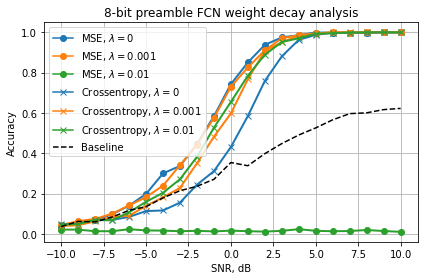

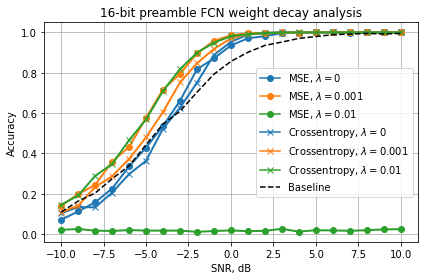

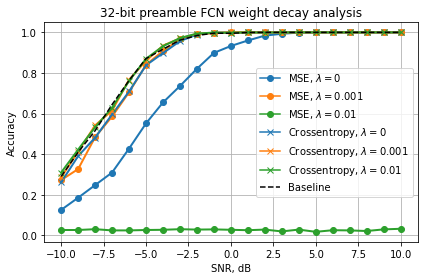

In [8]:
markers = ['o', 'x']
for train_snr, preamble_length, baseline in zip(train_snrs, preamble_lengths, baselines):
#     fig, ax = plt.subplots(1,3, figsize=(16,4))
    plt.figure()
    for j, loss_fn in enumerate(loss_fns):
        for i, reg in enumerate(regs):
        
            results = torch.load(f"results/{preamble_length}_preamble_{train_snr}_cfo_{add_cfo}_{str(loss_fn).strip('()')}_reg_{reg}.pt")
#             best,worst = find_best_worst(results)
            ders = np.mean([1-result['ders'] for result in results],axis=0)
#             ders = 1-results[best]['ders']
            plt.plot(snr_range, ders, f'-C{i}{markers[j]}', linewidth=2)
    plt.plot(snr_range, 1-baselines[baseline], 'k--')
    custom_lines = [Line2D([0], [0], color='C0', marker='o'),
                    Line2D([0], [0], color='C1', marker='o'),
                    Line2D([0], [0], color='C2', marker='o'),
                    Line2D([0], [0], color='C0', marker='x'),
                    Line2D([0], [0], color='C1', marker='x'),
                    Line2D([0], [0], color='C2', marker='x'),
                    Line2D([0], [0], color='k', linestyle='--')]
    plt.legend(custom_lines, [r'MSE, $\lambda=0$', r'MSE, $\lambda=0.001$', r'MSE, $\lambda=0.01$',
                              r'Crossentropy, $\lambda=0$', r'Crossentropy, $\lambda=0.001$', r'Crossentropy, $\lambda=0.01$',
                              'Baseline'])
    plt.grid()
    plt.xlabel('SNR, dB'); plt.ylabel('Accuracy')
    plt.title(f'{preamble_length}-bit preamble FCN weight decay analysis')
    plt.tight_layout()
    # plt.savefig(f'figures/fcn_train_weight_decay_results_{preamble_length}_preamble.png', dpi=300, bbox_inches='tight')

## Dropout

In [9]:
class preamble_detector(nn.Module):
    def __init__(self, num_layers, num_filters, width, drop_p=0.25):
        super(preamble_detector, self).__init__()
        
        pad = int((width-1)/2)
        
        self.conv = torch.nn.Sequential()
        
        self.conv.add_module("conv0", torch.nn.Conv2d(1, num_filters, (2,width), 1, padding=(0,pad)))
        self.conv.add_module(f"relu0", torch.nn.ReLU())
        self.conv.add_module(f"dropout0", torch.nn.Dropout(drop_p))
        
        for i in range(num_layers-2):
            self.conv.add_module(f"conv{i+1}", nn.Conv2d(num_filters, num_filters, (1,width), 1, padding=(0,pad)))
            self.conv.add_module(f"relu{i+1}", torch.nn.ReLU())
            self.conv.add_module(f"dropout{i+1}", torch.nn.Dropout(drop_p))
        
        self.conv.add_module(f"conv_last", nn.Conv2d(num_filters, 1, 1, 1))

    def forward(self, x):

        # Do all convolutions
        x = self.conv(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x

In [10]:
# train_snr = 0
# train_snrs = [10, 5, 0]
# preamble_length = 32
# preamble_lengths = [8, 16, 32]

# num_models = 5
# num_epochs = 30
# batch_size = 32
# lr = 0.001
# reg = 0
# regs = [0, 0.001, 0.01]
# drops = [0, 0.25, 0.5]

# add_cfo = True
# max_cfo = 10e3
# num_data = 8192

# num_layers = 3
# num_filters = 32
# filter_width = 35

# # loss_fn = nn.MSELoss()
# # loss_fn = nn.CrossEntropyLoss()
# loss_fns = [nn.MSELoss(), nn.CrossEntropyLoss()]

In [11]:
drops = [0, 0.25, 0.5]
reg = 0

In [12]:
for train_snr, preamble_length in zip(train_snrs, preamble_lengths):
    print(f'Training {preamble_length}-bit models on {train_snr}dB SNR...')
    for drop in drops:
        print(f'Dropout {drop}')
        for loss_fn in loss_fns:
            print(f'Using {str(loss_fn)} loss')
            # training data
            train_data, labels = gen_training_data(signal.max_len_seq(6)[0][:preamble_length], num_examples=num_data, snr=train_snr, add_phase_offset=True, 
                                                   add_carrier_offset=add_cfo, max_carrier_offset=max_cfo)
            train_data, labels = preprocess(train_data, labels)

            train_dataset = torch.utils.data.TensorDataset(train_data, labels)
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            # validation data
            val_data, val_labels = gen_training_data(signal.max_len_seq(6)[0][:preamble_length], num_examples=256, snr=train_snr, add_phase_offset=True,
                                                     add_carrier_offset=add_cfo)
            val_data, val_labels = preprocess(val_data, val_labels)

            val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            models = []
            for i in range(num_models):
                print(f'Model {i}...')
                torch.manual_seed(i)
                detector = preamble_detector(num_layers, num_filters, filter_width, drop_p=drop)
                detector.cuda()

                optimizer = optim.Adam(detector.parameters(), lr=lr, weight_decay=reg)

                detector, losses, val_losses, accs, val_accs = train_model(detector, optimizer, loss_fn, train_loader, val_loader, num_epochs=num_epochs)

                model_config = {"weights": detector.state_dict(),
                                "losses": losses,
                                "val_losses": val_losses,
                                "accs": accs,
                                "val_accs": val_accs,
                                "num_epochs": num_epochs,
                                "lr": lr,
                                "reg": reg,
                                "dropout": drop}

                models.append(model_config)
            torch.save(models, f"models/{preamble_length}_preamble_{train_snr}_cfo_{add_cfo}_{str(loss_fn).strip('()')}_reg_{reg}_dropout_{drop}.pt")

Training 8-bit models on 10dB SNR...
Dropout 0
Using MSELoss() loss
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Using CrossEntropyLoss() loss
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Dropout 0.25
Using MSELoss() loss
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Using CrossEntropyLoss() loss
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Dropout 0.5
Using MSELoss() loss
Model 0...
Model 1...


KeyboardInterrupt: 

In [ ]:
for train_snr, preamble_length in zip(train_snrs, preamble_lengths):
    print(f'Evaling {preamble_length}-bit models')
    for drop in drops:
        print(f'Dropout {drop}')
        for loss_fn in loss_fns:
            models = torch.load(f"models/{preamble_length}_preamble_{train_snr}_cfo_{add_cfo}_{str(loss_fn).strip('()')}_reg_{reg}_dropout_{drop}.pt")
            results = []
            for model in models:
                detector = preamble_detector(num_layers,num_filters,filter_width)
                detector.load_state_dict(model['weights'])
                detector.eval()

                ders = test_detector(detector, signal.max_len_seq(6)[0][:preamble_length], num_iter=200, add_phase_offset=True, 
                                         carrier_offset=None, add_channel=False, snr_range=snr_range)

                result = {"ders": ders,
                          "model": model,
                          "snr_range": snr_range,
                          "train_snr": train_snr}

                results.append(result)

            torch.save(results, f"results/{preamble_length}_preamble_{train_snr}_cfo_{add_cfo}_{str(loss_fn).strip('()')}_reg_{reg}_dropout_{drop}.pt")

Evaling 8-bit models
Dropout 0
Dropout 0.25
Dropout 0.5
Evaling 16-bit models
Dropout 0
Dropout 0.25
Dropout 0.5
Evaling 32-bit models
Dropout 0
Dropout 0.25
Dropout 0.5


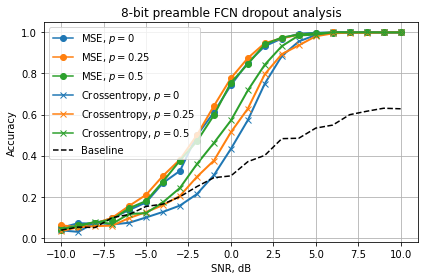

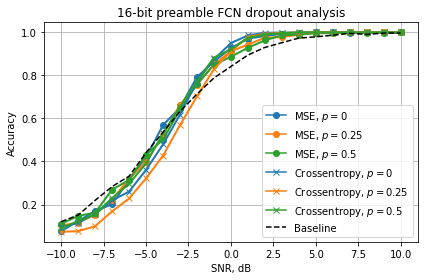

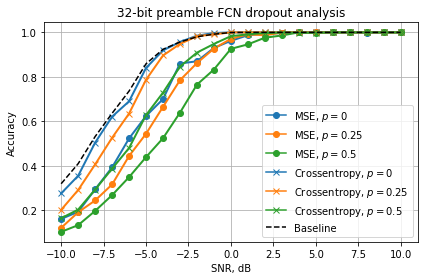

In [ ]:
for train_snr, preamble_length, baseline in zip(train_snrs, preamble_lengths, baselines):
#     fig, ax = plt.subplots(1,3, figsize=(16,4))
    plt.figure()
    for j, loss_fn in enumerate(loss_fns):
        for i, drop in enumerate(drops):
        
            results = torch.load(f"results/{preamble_length}_preamble_{train_snr}_cfo_{add_cfo}_{str(loss_fn).strip('()')}_reg_{reg}_dropout_{drop}.pt")
#             best,worst = find_best_worst(results)
            ders = np.mean([1-result['ders'] for result in results],axis=0)
#             ders = 1-results[best]['ders']
            plt.plot(snr_range, ders, f'-C{i}{markers[j]}', linewidth=2)
    plt.plot(snr_range, 1-baselines[baseline], 'k--')
    custom_lines = [Line2D([0], [0], color='C0', marker='o'),
                    Line2D([0], [0], color='C1', marker='o'),
                    Line2D([0], [0], color='C2', marker='o'),
                    Line2D([0], [0], color='C0', marker='x'),
                    Line2D([0], [0], color='C1', marker='x'),
                    Line2D([0], [0], color='C2', marker='x'),
                    Line2D([0], [0], color='k', linestyle='--')]
    plt.legend(custom_lines, [r'MSE, $p=0$', r'MSE, $p=0.25$', r'MSE, $p=0.5$',
                              r'Crossentropy, $p=0$', r'Crossentropy, $p=0.25$', r'Crossentropy, $p=0.5$',
                              'Baseline'])
    plt.grid()
    plt.xlabel('SNR, dB'); plt.ylabel('Accuracy')
    plt.title(f'{preamble_length}-bit preamble FCN dropout analysis')
    plt.tight_layout()
    # plt.savefig(f'figures/fcn_train_dropout_results_{preamble_length}_preamble.png', dpi=300, bbox_inches='tight')